--- INICIANDO ANÁLISE EXPLORATÓRIA DE DADOS (EDA) ---
✅ Dados IBGE carregados e preparados.
✅ Dados CGU carregados e preparados.
✅ Dados ATLAS carregados e preparados.

--- GERANDO VISUALIZAÇÕES ---


/tmp/ipykernel_18681/3414572581.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


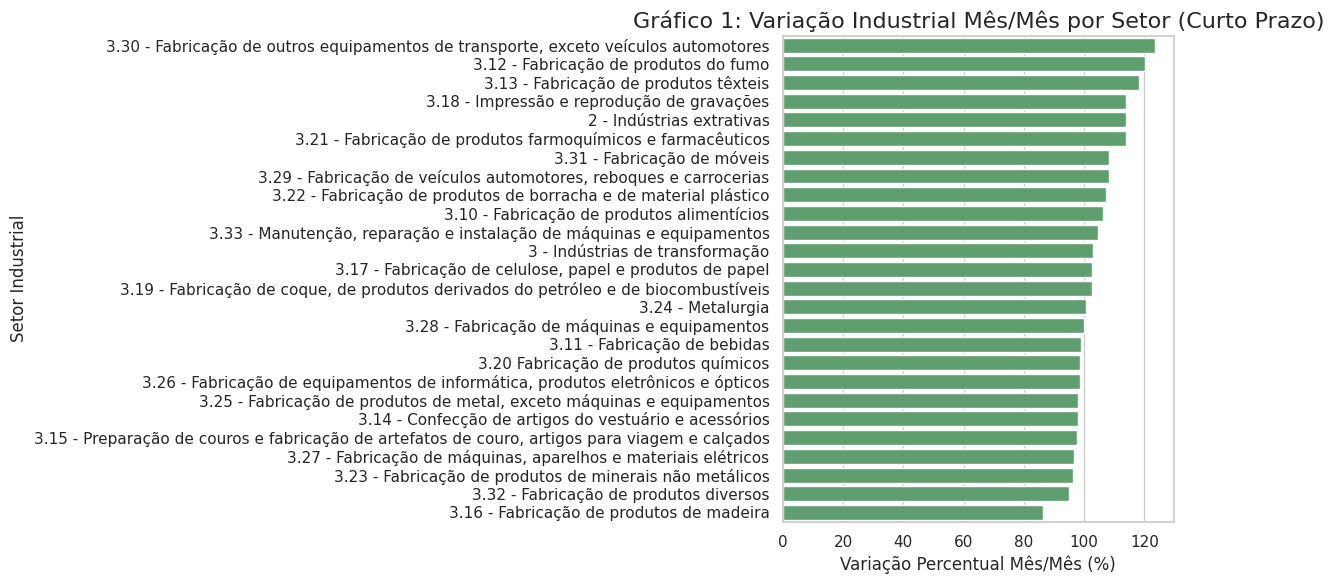

Gráfico 1: Barras - Variação Industrial Mês gerado.


/tmp/ipykernel_18681/3414572581.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


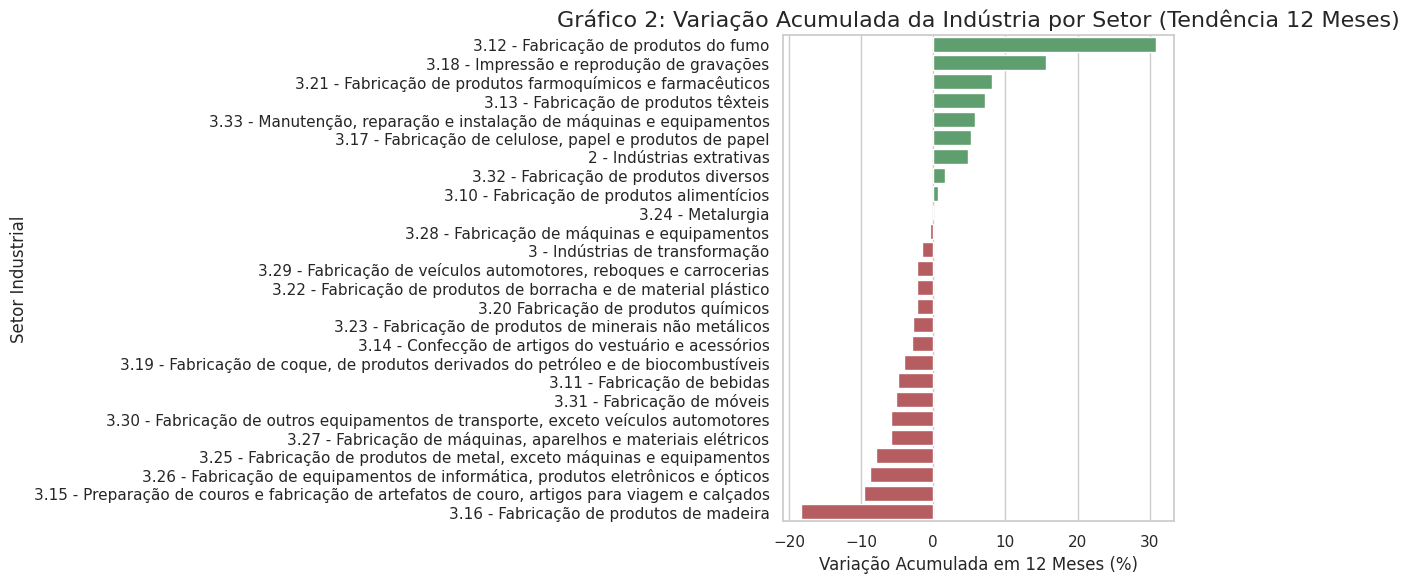

Gráfico 2: Barras - Variação Acumulada 12 Meses (Tendência) gerado.


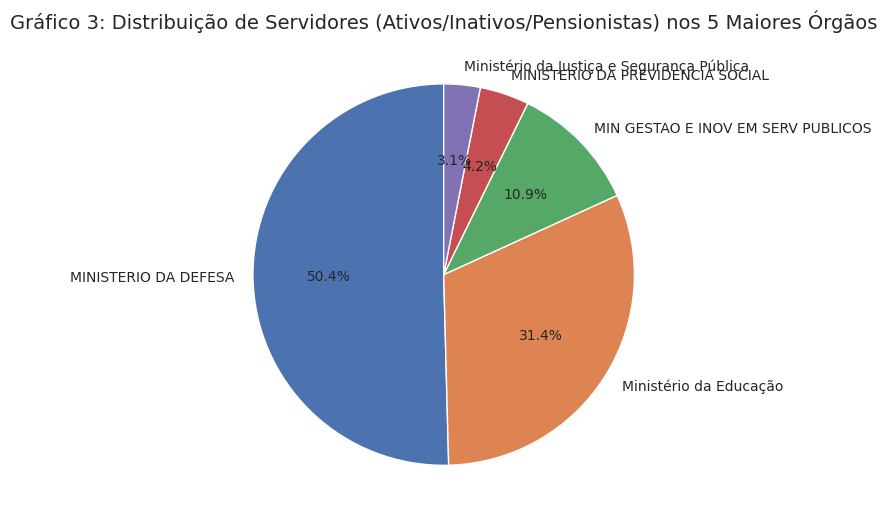

Gráfico 3: Pizza - Distribuição de Servidores (CGU) gerado.


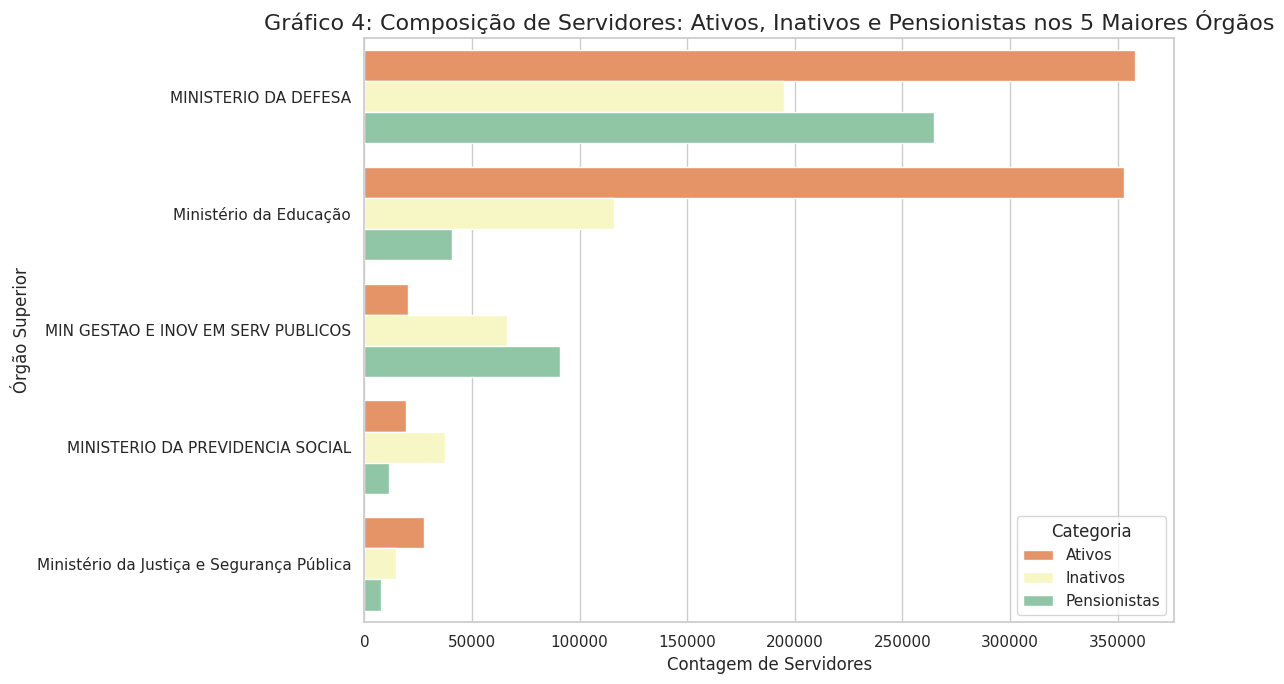

Gráfico 4: Barras Empilhadas - Composição de Servidores (CGU) gerado.


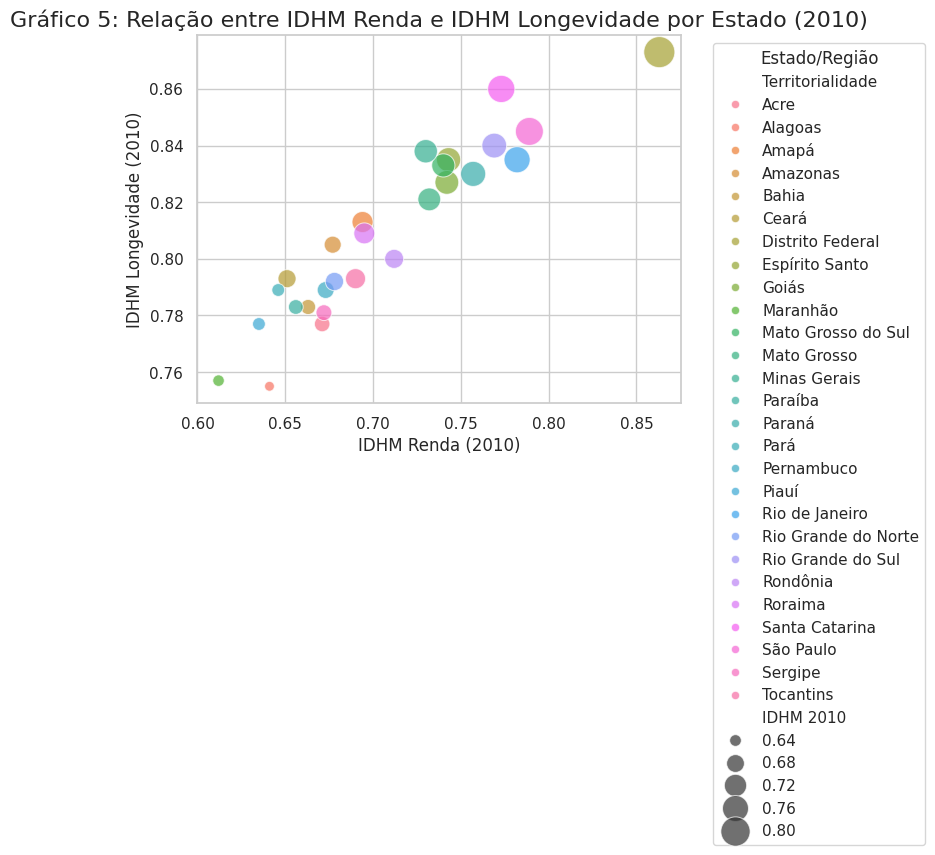

Gráfico 5: Dispersão - Renda vs Longevidade (Atlas) gerado.


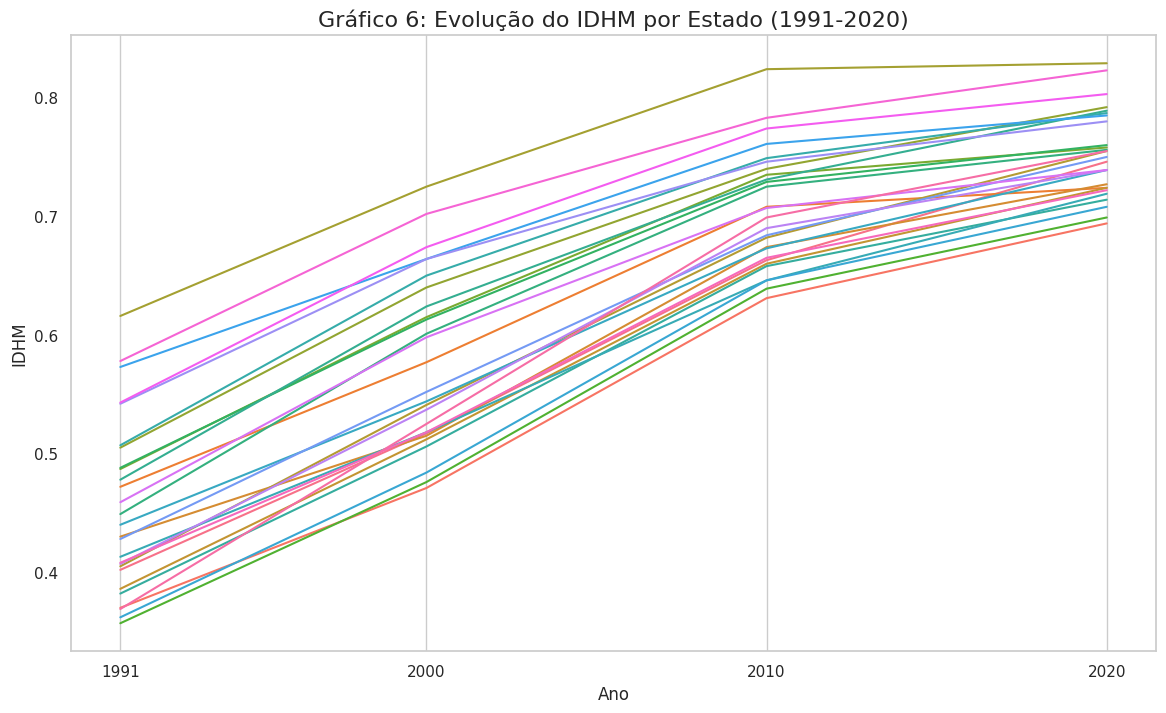

Gráfico 6: Linhas - Evolução do IDHM (Atlas) gerado.

--- EDA CONCLUÍDA ---


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuração de estilo para Seaborn
sns.set_theme(style="whitegrid")

# Dicionário de caminhos dos arquivos de dados
data_paths = {
    'IBGE_PIMPF': '../data/PIMPF - Produção física industrial por seções e atividades industriais.xlsx',
    'CGU_SERVIDORES': '../data/servidorPorOrgao.csv',
    'ATLAS_IDHM': '../data/Atlas.xlsx' 
}

# Lista de colunas para filtrar o Atlas
COLUNAS_ATLAS = [
    'Territorialidades', 
    'IDHM 1991',  
    'IDHM 2000',  
    'IDHM 2010',  
    'IDHM 2020',  
    'IDHM Renda 2010', 'IDHM Longevidade 2010', 'IDHM Educação 2010'
]

print("--- INICIANDO ANÁLISE EXPLORATÓRIA DE DADOS (EDA) ---")

# --- 1. FUNÇÕES DE CARREGAMENTO E PREPARAÇÃO ---

def carregar_e_preparar_dados():
    """Carrega, limpa e retorna os DataFrames para visualização."""
    dataframes = {}
    
    # 1.1 CARREGAMENTO IBGE (PIMPF) - ATUALIZADO
    try:
        # Carrega com o header correto (linha 4 = índice 3)
        df_ibge = pd.read_excel(data_paths['IBGE_PIMPF'], header=3) 
        
        # Limpeza e Renomeação de Colunas
        df_ibge.columns = df_ibge.columns.str.strip()
        
        df_ibge = df_ibge.rename(columns={
            df_ibge.columns[0]: 'Seções e atividades industriais', 
            df_ibge.columns[2]: 'Variação percentual mês/mês imediatamente anterior (com ajuste sazonal)',
            df_ibge.columns[4]: 'Variação 12 meses (%)' # NOVO: Coluna de Variação de 12 meses (Índice 4)
        })
        
        coluna_variacao = 'Variação percentual mês/mês imediatamente anterior (com ajuste sazonal)'

        # Limpeza de Dados Vazios e Não Numéricos
        df_ibge[coluna_variacao] = pd.to_numeric(df_ibge[coluna_variacao], errors='coerce')
        df_ibge['Variação 12 meses (%)'] = pd.to_numeric(df_ibge['Variação 12 meses (%)'], errors='coerce')
        
        df_ibge.dropna(subset=[coluna_variacao, 'Variação 12 meses (%)'], inplace=True)
        
        # Remoção da linha de total geral (primeira linha)
        if not df_ibge.empty:
            df_ibge_total = df_ibge.iloc[0:1].copy() # Salva a linha de total (índice 0)
            df_ibge = df_ibge.iloc[1:].copy() # Remove a linha de total dos setores
        
        # Foca nas colunas necessárias para o gráfico mensal e de 12 meses
        df_ibge = df_ibge[['Seções e atividades industriais', coluna_variacao, 'Variação 12 meses (%)']]
        
        dataframes['IBGE_PIMPF'] = df_ibge
        dataframes['IBGE_PIMPF_TOTAL'] = df_ibge_total # Adiciona o Total para o Gráfico de Tendência
        print("✅ Dados IBGE carregados e preparados.")
    except Exception as e:
        print(f"❌ Erro ao carregar IBGE: {e}")
        
    # 1.2 CARREGAMENTO CGU (SERVIDORES)
    try:
        df_cgu = pd.read_csv(data_paths['CGU_SERVIDORES'], delimiter=';')
        
        # Limpeza e Renomeação
        df_cgu = df_cgu.drop(columns=['Unnamed: 5'])
        df_cgu.rename(columns={'Servidores': 'Ativos'}, inplace=True)
        df_cgu = df_cgu[df_cgu['Órgão Superior Lotação'] != 'Sem informação']
        
        # Agrupamento e Cálculo
        df_cgu_agrupado = df_cgu.groupby('Órgão Superior Lotação')[['Ativos', 'Inativos', 'Pensionistas']].sum().reset_index()
        df_cgu_agrupado['Total'] = df_cgu_agrupado[['Ativos', 'Inativos', 'Pensionistas']].sum(axis=1)
        
        # Filtra para os 5 maiores
        df_cgu_top5 = df_cgu_agrupado.nlargest(5, 'Total')
        dataframes['CGU_SERVIDORES'] = df_cgu_top5
        print("✅ Dados CGU carregados e preparados.")
    except Exception as e:
        print(f"❌ Erro ao carregar CGU: {e}")

    # 1.3 CARREGAMENTO ATLAS (IDHM)
    try:
        # O arquivo é .xlsx, lido como Excel
        df_atlas = pd.read_excel(data_paths['ATLAS_IDHM']) 
        
        # Limpeza e Renomeação
        df_atlas.columns = df_atlas.columns.str.strip()
        
        # Filtra as colunas (incluindo 1991, 2000, 2020)
        df_atlas = df_atlas[COLUNAS_ATLAS]
        df_atlas.columns = ['Territorialidade', 'IDHM 1991', 'IDHM 2000', 'IDHM 2010', 'IDHM 2020', 'Renda_2010', 'Longevidade_2010', 'Educacao_2010']
        df_atlas.dropna(inplace=True)
        
        # Exclui a linha do Brasil
        df_atlas = df_atlas[df_atlas['Territorialidade'] != 'Brasil']
        dataframes['ATLAS_IDHM'] = df_atlas
        print("✅ Dados ATLAS carregados e preparados.")
    except Exception as e:
        print(f"❌ Erro ao carregar ATLAS: {e}")

    return dataframes
        
dataframes = carregar_e_preparar_dados()


# --- 2. GERAÇÃO DOS GRÁFICOS ---

print("\n--- GERANDO VISUALIZAÇÕES ---")

# 2.1 GRÁFICO 1: IBGE - GRÁFICO DE BARRAS (Variação Industrial Mês)
if 'IBGE_PIMPF' in dataframes and not dataframes['IBGE_PIMPF'].empty:
    plt.figure(figsize=(12, 6))
    df_ibge = dataframes['IBGE_PIMPF']
    
    # Ordena para melhor visualização
    df_ibge = df_ibge.sort_values(by='Variação percentual mês/mês imediatamente anterior (com ajuste sazonal)', ascending=False)
    
    # Mapeia cores
    cores = ['g' if x >= 0 else 'r' for x in df_ibge['Variação percentual mês/mês imediatamente anterior (com ajuste sazonal)']]
    
    sns.barplot(
        x='Variação percentual mês/mês imediatamente anterior (com ajuste sazonal)', 
        y='Seções e atividades industriais', 
        data=df_ibge, 
        palette=cores, 
        orient='h'
    )
    plt.title('Gráfico 1: Variação Industrial Mês/Mês por Setor (Curto Prazo)', fontsize=16)
    plt.xlabel('Variação Percentual Mês/Mês (%)', fontsize=12)
    plt.ylabel('Setor Industrial', fontsize=12)
    plt.tight_layout()
    plt.show()
    print("Gráfico 1: Barras - Variação Industrial Mês gerado.")
elif 'IBGE_PIMPF' in dataframes:
    print("Gráfico 1: Dados IBGE vazios após filtragem. O gráfico não foi gerado.")


# --- NOVO GRÁFICO DE TENDÊNCIA ---
# 2.2 GRÁFICO 5: IBGE - GRÁFICO DE BARRAS (Variação Acumulada em 12 Meses)
if 'IBGE_PIMPF' in dataframes and not dataframes['IBGE_PIMPF'].empty:
    plt.figure(figsize=(12, 6))
    df_ibge_tendencia = dataframes['IBGE_PIMPF'].sort_values(by='Variação 12 meses (%)', ascending=False)
    
    # Mapeia cores
    cores_tendencia = ['g' if x >= 0 else 'r' for x in df_ibge_tendencia['Variação 12 meses (%)']]
    
    sns.barplot(
        x='Variação 12 meses (%)', 
        y='Seções e atividades industriais', 
        data=df_ibge_tendencia, 
        palette=cores_tendencia, 
        orient='h'
    )
    plt.title('Gráfico 2: Variação Acumulada da Indústria por Setor (Tendência 12 Meses)', fontsize=16)
    plt.xlabel('Variação Acumulada em 12 Meses (%)', fontsize=12)
    plt.ylabel('Setor Industrial', fontsize=12)
    plt.tight_layout()
    plt.show()
    print("Gráfico 2: Barras - Variação Acumulada 12 Meses (Tendência) gerado.")


# 2.3 GRÁFICO 2: CGU - GRÁFICO DE PIZZA (Distribuição Servidores - Top 5)
if 'CGU_SERVIDORES' in dataframes:
    plt.figure(figsize=(8, 8))
    df_cgu_top5 = dataframes['CGU_SERVIDORES']
    
    # Gráfico de pizza
    plt.pie(
        df_cgu_top5['Total'], 
        labels=df_cgu_top5['Órgão Superior Lotação'], 
        autopct='%1.1f%%', 
        startangle=90,
        textprops={'fontsize': 10}
    )
    plt.title('Gráfico 3: Distribuição de Servidores (Ativos/Inativos/Pensionistas) nos 5 Maiores Órgãos', fontsize=14)
    plt.tight_layout()
    plt.show()
    print("Gráfico 3: Pizza - Distribuição de Servidores (CGU) gerado.")


# 2.4 GRÁFICO 5 (Antigo 2.3): CGU - COMPOSIÇÃO (ATIVOS, INATIVOS, PENSIONISTAS)
if 'CGU_SERVIDORES' in dataframes:
    plt.figure(figsize=(12, 7))
    df_cgu_top5 = dataframes['CGU_SERVIDORES']
    
    # Transforma o DataFrame de "largo" para "longo" para usar no Seaborn Stacked Bar
    df_longo_cgu = df_cgu_top5.melt(
        id_vars='Órgão Superior Lotação', 
        value_vars=['Ativos', 'Inativos', 'Pensionistas'],
        var_name='Tipo de Servidor', 
        value_name='Contagem'
    )
    
    # Gera o gráfico de barras empilhadas
    sns.barplot(
        x='Contagem', 
        y='Órgão Superior Lotação', 
        hue='Tipo de Servidor', 
        data=df_longo_cgu, 
        palette='Spectral',
        orient='h'
    )
    
    plt.title('Gráfico 4: Composição de Servidores: Ativos, Inativos e Pensionistas nos 5 Maiores Órgãos', fontsize=16)
    plt.xlabel('Contagem de Servidores', fontsize=12)
    plt.ylabel('Órgão Superior', fontsize=12)
    plt.legend(title='Categoria')
    plt.tight_layout()
    plt.show()
    print("Gráfico 4: Barras Empilhadas - Composição de Servidores (CGU) gerado.")


# 2.5 GRÁFICO 3 (Antigo 2.4): ATLAS - GRÁFICO DE DISPERSÃO (Renda vs Longevidade)
if 'ATLAS_IDHM' in dataframes:
    plt.figure(figsize=(10, 7))
    df_atlas = dataframes['ATLAS_IDHM']
    
    # Gráfico de dispersão
    sns.scatterplot(
        x='Renda_2010', 
        y='Longevidade_2010', 
        data=df_atlas, 
        hue='Territorialidade', 
        size='IDHM 2010', 
        sizes=(50, 500),        
        alpha=0.7               
    )
    
    plt.title('Gráfico 5: Relação entre IDHM Renda e IDHM Longevidade por Estado (2010)', fontsize=16)
    plt.xlabel('IDHM Renda (2010)', fontsize=12)
    plt.ylabel('IDHM Longevidade (2010)', fontsize=12)
    plt.legend(title='Estado/Região', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=(0, 0, 0.85, 1)) 
    plt.show()
    print("Gráfico 5: Dispersão - Renda vs Longevidade (Atlas) gerado.")


# 2.6 GRÁFICO 4 (Antigo 2.5): ATLAS - GRÁFICO DE LINHAS (Evolução do IDHM 1991-2020)
if 'ATLAS_IDHM' in dataframes:
    
    # 1. Prepara as colunas para o melt
    df_evolucao = dataframes['ATLAS_IDHM']
    colunas_idhm_anos = ['IDHM 1991', 'IDHM 2000', 'IDHM 2010', 'IDHM 2020']
    
    # 2. Transforma (Pivota) os dados: Muda de formato "largo" para "longo"
    df_longo = df_evolucao.melt(
        id_vars=['Territorialidade'], 
        value_vars=colunas_idhm_anos, 
        var_name='Ano', 
        value_name='IDHM'
    )
    
    # 3. Limpa a coluna 'Ano' (remove o prefixo 'IDHM ')
    df_longo['Ano'] = df_longo['Ano'].str.replace('IDHM ', '').astype(int)
    
    plt.figure(figsize=(14, 8))
    
    # 4. Gera o Gráfico de Linhas
    sns.lineplot(
        x='Ano', 
        y='IDHM', 
        hue='Territorialidade', 
        data=df_longo, 
        legend=False 
    )
    
    plt.title('Gráfico 6: Evolução do IDHM por Estado (1991-2020)', fontsize=16)
    plt.xlabel('Ano', fontsize=12)
    plt.ylabel('IDHM', fontsize=12)
    plt.xticks(df_longo['Ano'].unique()) 
    plt.grid(axis='y')
    plt.show()
    print("Gráfico 6: Linhas - Evolução do IDHM (Atlas) gerado.")

print("\n--- EDA CONCLUÍDA ---")